# 以PTT NBA版做文字視覺化分析球員及球隊討論聲量

In [192]:
import pandas as pd
import numpy as np
import time
from collections import Counter
import jieba
from tqdm import tqdm_notebook
from module.text_module import *
import matplotlib.pyplot as plt
from fintextmin import *
import re
from wordcloud import WordCloud
from ast import literal_eval
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.font_manager as fm
import matplotlib
import re
import seaborn as sns

'/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf'

In [60]:
df = pd.read_csv("NBA_crawler1.csv", index_col=0)

In [61]:
df['type'] = df['標題'].apply(lambda x: x.split(" ")[0])

In [62]:
Counter(list(df['type'])).most_common()[:20]

[('[情報]', 3415),
 ('Re:', 3060),
 ('[討論]', 3043),
 ('[新聞]', 2528),
 ('[花邊]', 2400),
 ('[Live]', 1368),
 ('[公告]', 593),
 ('[外絮]', 515),
 ('[專欄]', 328),
 ('[BOX', 85),
 ('Fw:', 76),
 ('[發錢]', 52),
 ('[徵文]', 37),
 ('[分享]', 14),
 ('[出售]', 7),
 ('[心得]', 7),
 ('[祭品]', 5),
 ('[版務]', 4),
 ('[公告]水桶', 4),
 ('[發錢', 4)]

In [63]:
df = df[df['type'].isin(['[情報]','[討論]','[新聞]','[花邊]','[外絮]','[專欄]'])]
df.reset_index(drop=True, inplace=True)
df.head()

標題                        時間  \
0      [新聞] 湯瑪斯重返波士頓 厄文：球迷會歡迎他  Mon Jan  1 13:33:18 2018   
1    [新聞] 哈登夾人手還可以罰球 湖迷怒轟:裁判瞎了  Mon Jan  1 14:06:18 2018   
2        [新聞] 火箭總管：打敗勇士是我們唯一目標  Mon Jan  1 14:11:35 2018   
3  [花邊] Irving談對騎士:很期待，這會是一個考驗  Mon Jan  1 14:27:36 2018   
4   [花邊] NBA》科爾振奮：柯瑞復出 讓我老婆變美了  Mon Jan  1 15:36:31 2018   

                               作者  \
0             StressND (rmgooddd)   
1          Wojnarowski (@wojespn)   
2                       Yui5 (唯控)   
3  KyrieIrving1 (King of Celtics)   
4                   lovea (lovea)   

                                                  內文  \
0  \nhttps://nba.udn.com/nba/story/6780/2905733\n...   
1  \nNBA》哈登夾人手還可以罰球 湖迷怒轟：裁判瞎了？（影音）\n\n〔體育中心／綜合報導〕...   
2  \n火箭總管：打敗勇士是我們唯一目標\nhttp://www.chinatimes.com/...   
3  \nIrving談下場對陣騎士：很期待，這會是一個考驗\n\n虎撲1月1日訊\n\n在今天以...   
4  \nNBA》科爾振奮：柯瑞復出 讓我老婆變美了\n\nhttp://www.chinatim...   

                                                留言作者  \
0  [m791017, jenchieh5, jlincredible, aaron770708...   
1  [LENling, obryanto, mafitelak, arcss, swinging...   
2  [live147222, adamlovedogc, yuechen, yuechen, S...   
3  [hunt5566, she192224, woaifafewen, yuechen, wa...   
4  [tim1112, goal56, grayoasis, ilovedandan, Nana...   

                                                  留言  type  
0  [: 新大哥說話了！！, : 瑪斯:, : 有風度推, :  燒球衣歡迎, : 商場 球場 ...  [新聞]  
1  [: 剛剛那篇怎麼被刪了, : 這球滿誇張, : 突然發現op了就自刪ㄌ, : 鬍子慢動作手...  [新聞]  
2  [: 唯一目標是冠軍, : 還勇士 雷霆馬刺都不一定過關了, : 先打贏雷霆跟馬刺, : 不...  [新聞]  
3  [: 1:0, : Kyrie MVP, : 會去教LBJ做人, : 未看先猜LeBron守...  [花邊]  
4  [: 女為悅己者容, : 這麼綠也能高興@@, : Op, : 又在講幹話了, : 綠綠的,...  [花邊]

In [101]:
df['month'] = df['時間'].apply(lambda x:x.split(" ")[1])

In [105]:
month = df.groupby('month').count().reset_index()
month['index'] = month['month']
month_index = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
month['index'] = month['index'].map(month_index)
month = month.sort_values(by='index')

在PTT個月份的NBA討論熱度

Text(0.5, 0.98, 'count of monthly posts')

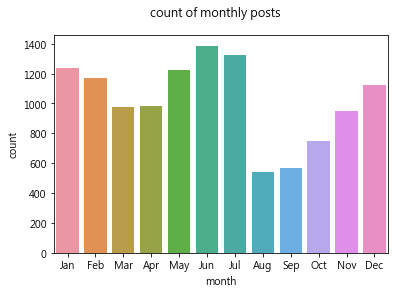

In [119]:
sns.countplot('month',data=df)
plt.suptitle('count of monthly posts')

In [65]:
doc_names = range(len(df))
text_list = list(df['內文'])

In [66]:
dwc = {key: [word for word in jieba.cut(text, cut_all=False)] for (key, text) in tqdm_notebook(zip(doc_names, text_list))}

In [67]:
#算次數之前先整理
def delete_eng_int(x_list):
    r1 = '[a-zA-Z0-9’!"#$─%&\'()*+,-.：/:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    x_list = [re.sub(r1,'', i).strip() for i in x_list]
    while '' in x_list:
        x_list.remove('')
    return x_list

In [68]:
dwc = {key: delete_eng_int(doc) for key,doc in dwc.items()}

In [69]:
dwc = {key: [i for i in doc if i not in ['◣','▲','－','▼','違反版','違反板','規請','資料','來源','錯誤','如有','告訴','謝謝','Ｗ','L','Ｌ','的','在','了','是']]for key,doc in dwc.items()}

In [70]:
dwc = {key: [i for i in doc if (len(i) > 1)]for key,doc in dwc.items()}

In [71]:
doc_word_frequency = {key: {i:Counter(doc)[i] for i in Counter(doc)} for key, doc in dwc.items()}

In [75]:
list(doc_word_frequency[1].items())[0:10]

[('哈登', 10),
 ('人手', 1),
 ('可以', 1),
 ('罰球', 2),
 ('湖迷怒', 1),
 ('裁判', 6),
 ('影音', 1),
 ('體育', 1),
 ('中心', 1),
 ('綜合', 1)]

In [76]:
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]

In [77]:
#找有哪些沒東西
nothing  = [i for i in range(len(dwf_list)) if (len(dwf_list[i]) < 1)]
#將他補為No的DataFrame
pd.DataFrame(1,index=['No'],columns=[0])

0
No  1

In [ ]:
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
#補齊
for i in nothing:
    dwf_list[i] = pd.DataFrame(1,index=['No'],columns=[0])
    
wfm = pd.concat(dwf_list, axis= 1)
wfm = np.transpose(wfm).fillna(0)
wfm.index = doc_word_frequency.keys()

puncs = set_puncs() 
wfm = wfm[list(set(wfm) - set(puncs))]
wfm.head() # 詞頻矩陣完成

In [413]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_gen = transformer.fit_transform(wfm) # 產生一個 tfidf 矩陣的 generator
df_tfidf = pd.DataFrame(tfidf_gen.toarray(), columns=wfm.columns)
df_tfidf.head()

票來  二連勝   人浪  不會罰   許有  叫的數  看不懂   忡忡   謝天  據美國  ...   比餅   勝負   首次  最後到  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    單幹   並長  灣時間  蘇思睿  醫來當   注一  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 26531 columns]

In [ ]:
first_text = wfm.to_dict(orient='records')[562] # 將詞頻矩陣轉換成dictionary, 把文章抽出來

TF-IDF看出什麼是這篇文章的重點討論主題

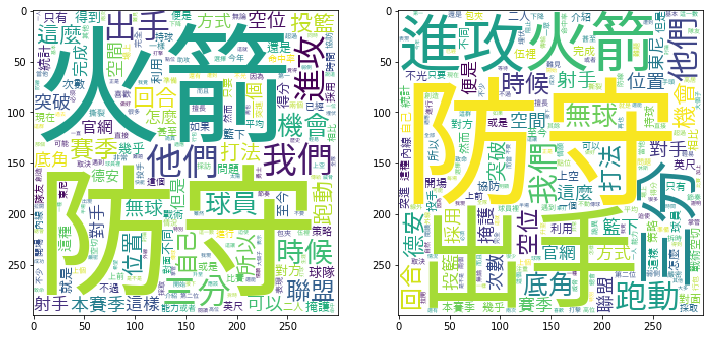

In [415]:
font = r'/Users/howardchung/PPT/字體/TaipeiSansTCBeta-Regular.ttf'

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plot_wordcloud(first_text, ax=ax1, font_path=font, height=300, width=300)

ax2 = plt.subplot(122)
plot_tfidf_wordcloud(df_tfidf, text_index=562, ax=ax2, font_path=font, height=300, width=300) 

以詞頻長條圖展示

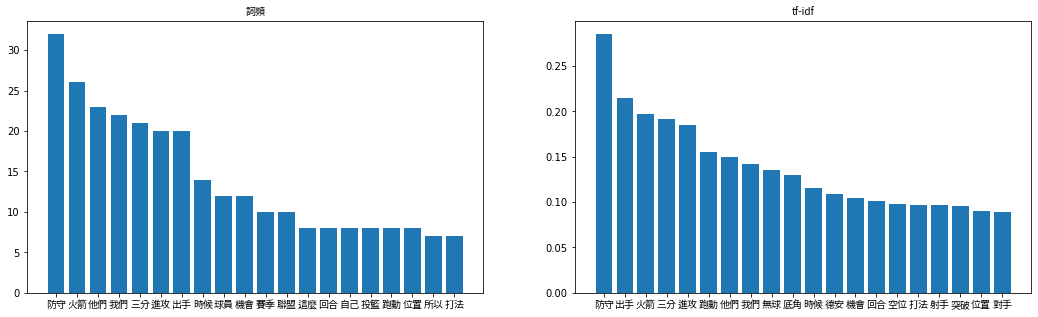

In [417]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
plot_tf_bar(first_text, ax=ax1, font_path=font, title="詞頻")

ax2 = plt.subplot(122)
plot_tfidf_bar(df_tfidf, text_index=562, ax=ax2, font_path=font, title="tf-idf") 

In [ ]:
rank = pd.read_csv('rank.csv',index_col=0)
group_lk = rank.set_index('name')['group'].to_dict()
colors = dict(zip(
    ["players","teams"],
    ["#90d595", "#f7bb5f"]
))

fig, ax = plt.subplots(figsize=(15, 8))

def draw_barchart(current_year):
    dff = rank[rank['month'].eq(current_year)].sort_values(by='count', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['name'], dff['count'], color=[colors[group_lk[x]] for x in dff['name']])
    dx = dff['count'].max() / 200
    for i, (value, name) in enumerate(zip(dff['count'], dff['name'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, current_year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'content', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'The most discussed player/team in the NBA from 201801 ~ 201812',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @HowardChung', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(1)

球員/球隊聲量變化

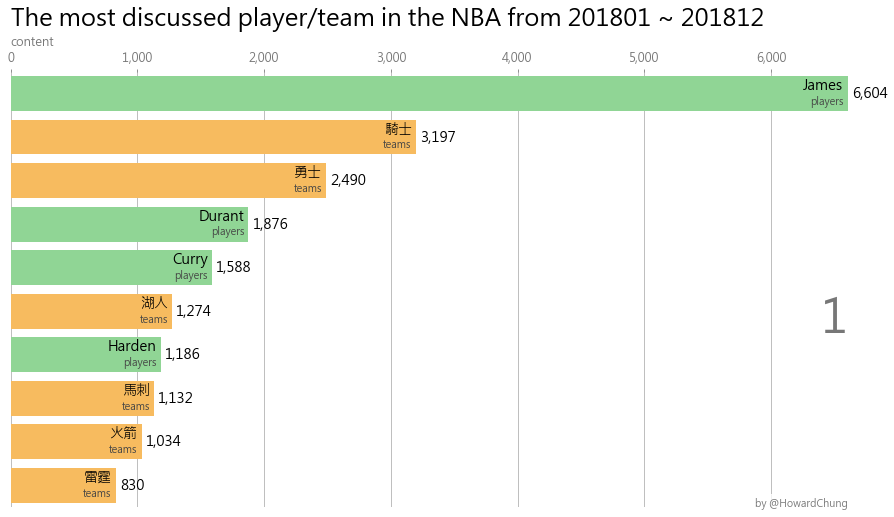

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 13))
HTML(animator.to_jshtml())

In [169]:
team_rank = rank[rank['group']=='teams'].groupby('name').sum().reset_index().sort_values(by='count')

球隊聲量統計

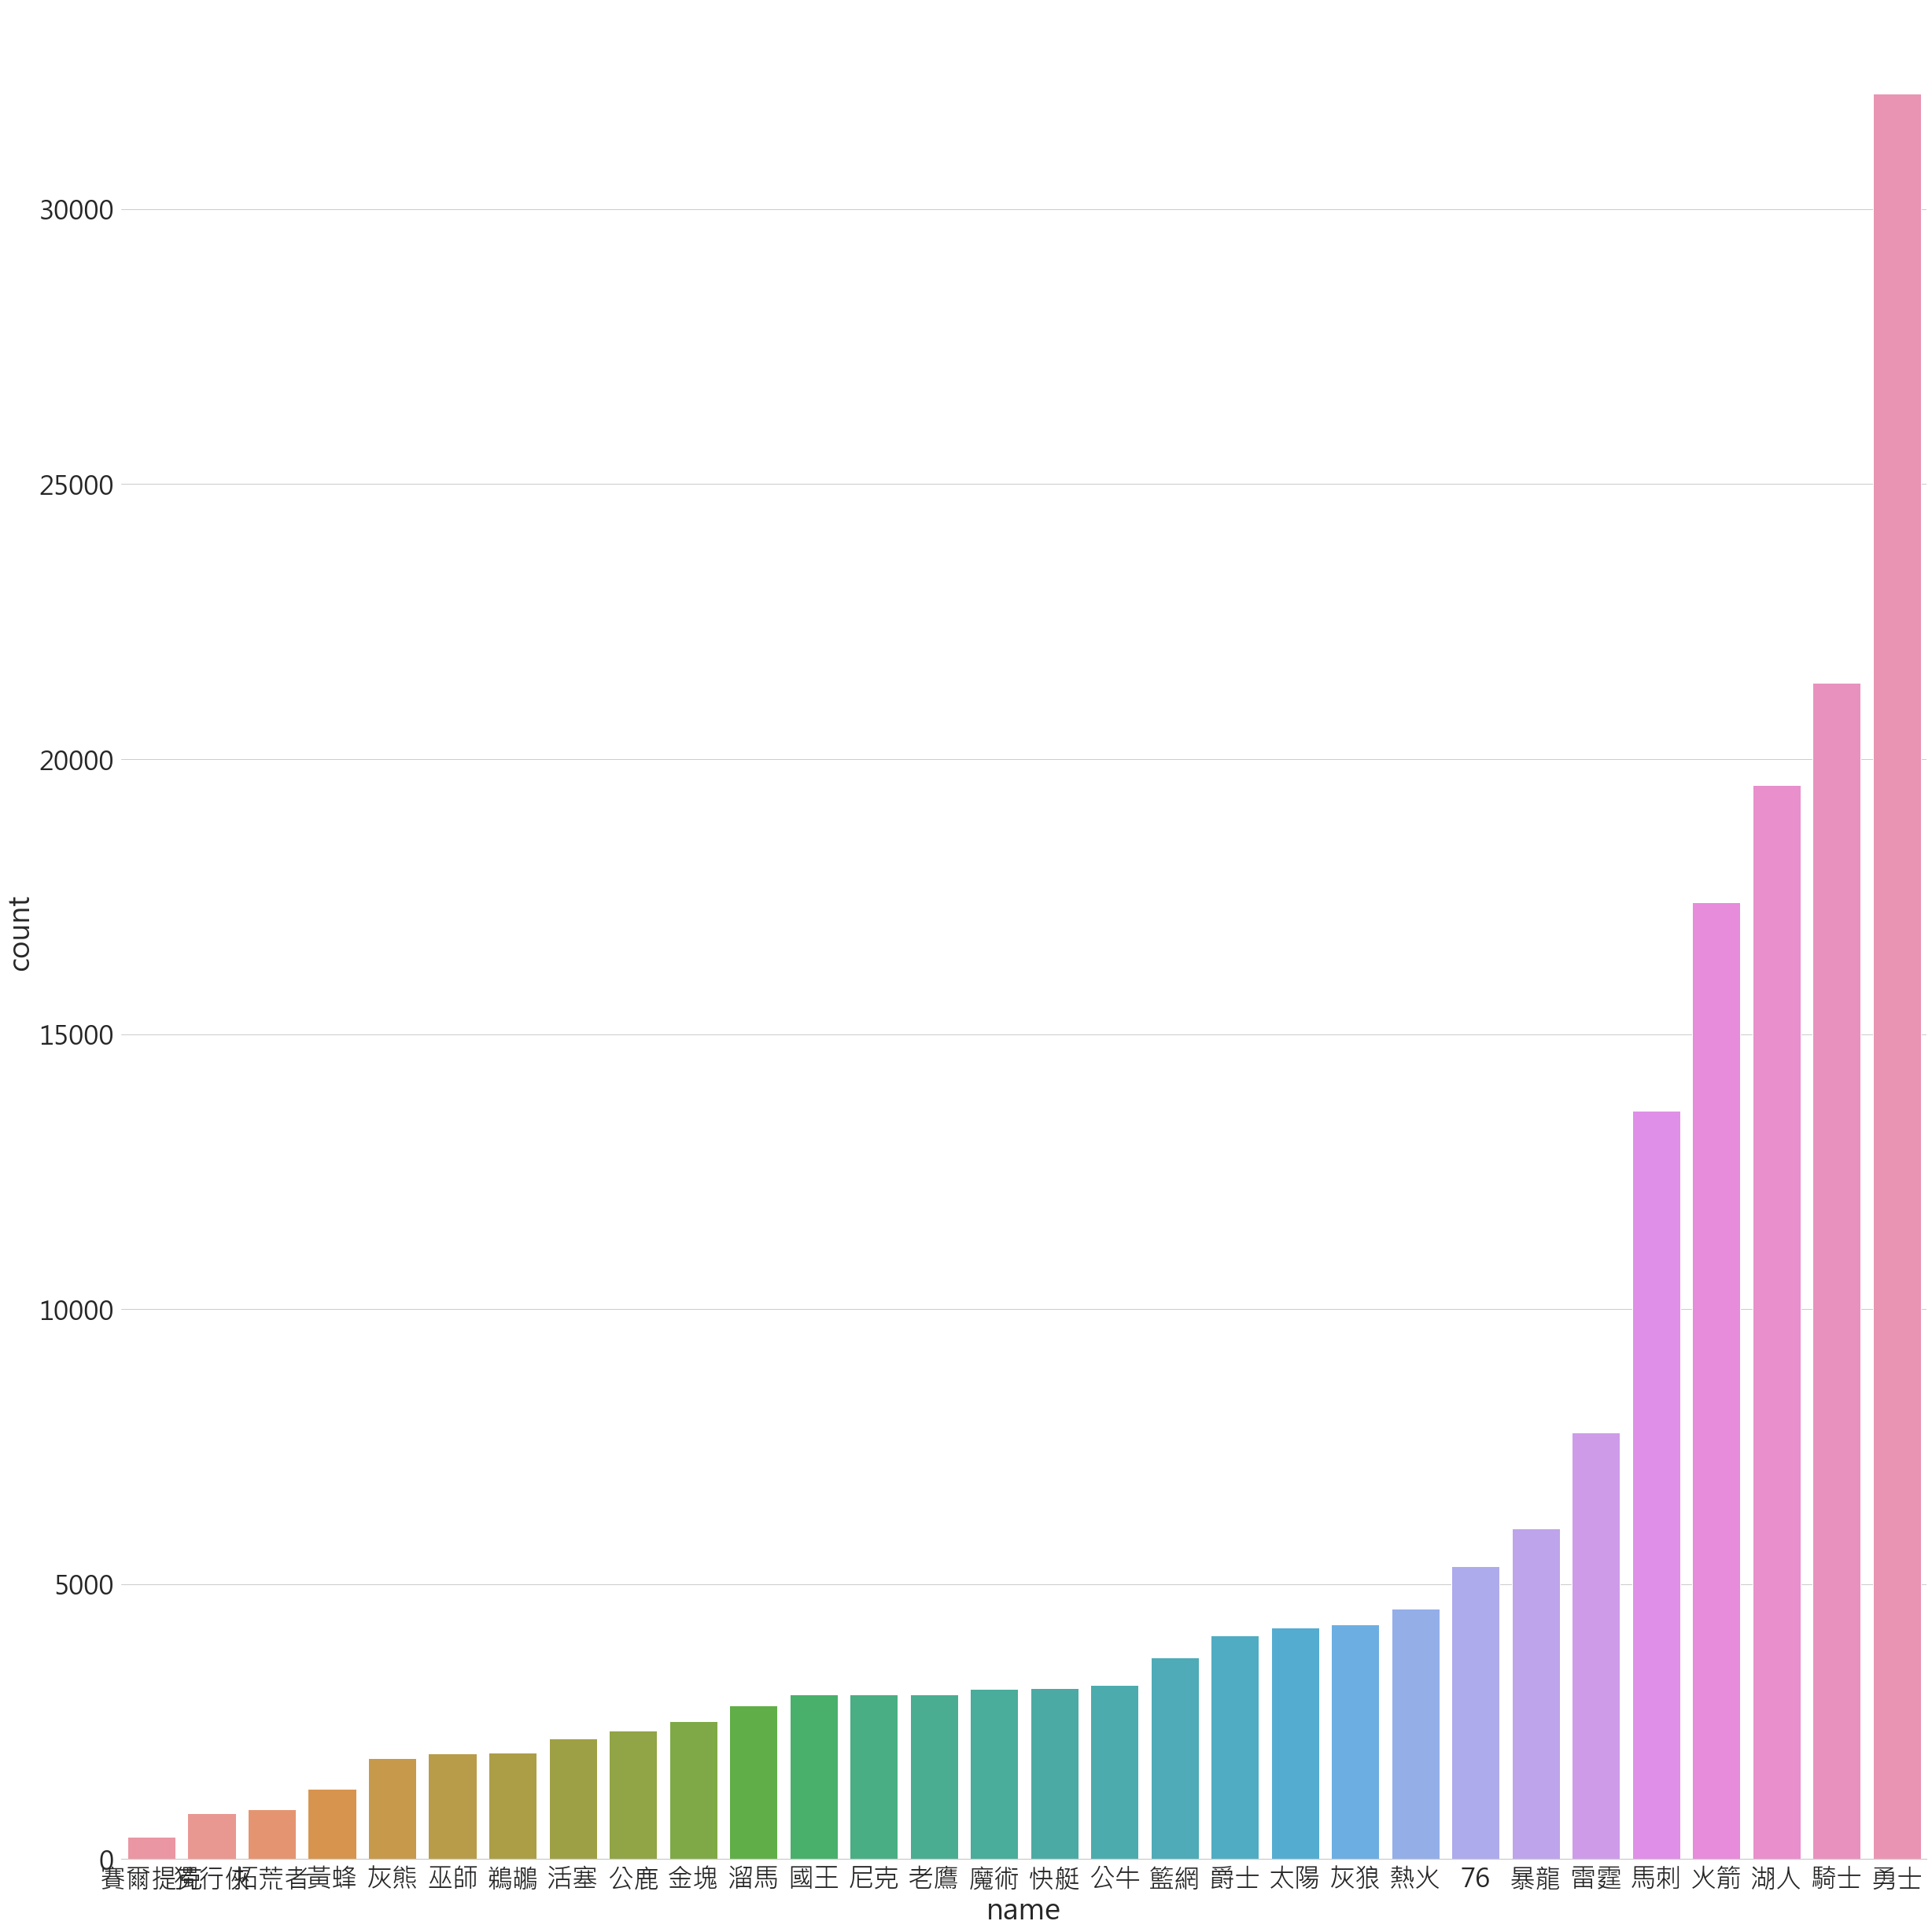

In [177]:
myfont=FontProperties(fname=r'/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf',size=14)
sns.set(font=myfont.get_family())
sns.set(font_scale=3)
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
g = sns.catplot(x="name",y="count",data=team_rank,kind="bar",height = 35)
g.despine(left=True)
g = g.set_ylabels("count")

馬刺沒什麼出現表現聲量怎麼會高？

In [174]:
spurs = rank[rank['name'] == '馬刺']

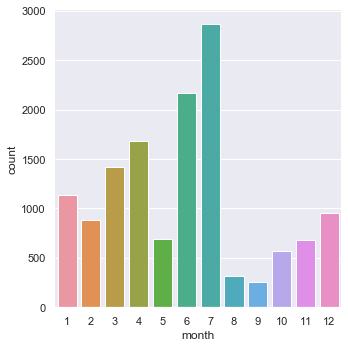

In [185]:
sns.set(font_scale=1)
g = sns.catplot(x="month",y="count",data=spurs,kind="bar")
g.despine(left=True)
g = g.set_ylabels("count")